In [1]:
!git clone https://github.com/skaldek/ImageNet-Datasets-Downloader DOWNLOADER
!mkdir DATA
# vehicle armored car fishing boat airplane bumper car
!python DOWNLOADER/downloader.py \
    -data_root DATA \
    -use_class_list True \
    -class_list n06255081 n02739889 n03351262 n02691156 n02918964 \
    -images_per_class 10000

fatal: destination path 'DOWNLOADER' already exists and is not an empty directory.
A subdirectory or file DATA already exists.


^C


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from skimage import color

import dataset
import model

In [2]:
def show(images, size=(10, 10), grayscale=False):
    plt.figure()
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

    rows = int(np.ceil(len(images) / 3.0))

    if grayscale:
        m = images
    else:
        m = model.Model.lab_to_rgb(images)
    for i, image in enumerate(m):
        plt.subplot(rows, 3, i + 1)

        if grayscale:
            image = image[0, :, :]
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)
        plt.axis("off")
    plt.show()

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1
NVIDIA GeForce GTX 1060 6GB


In [4]:
def H_inv(y_batch, q_to_ab):
    # values between 0 and 100 and -110 to +110
    b, c, h, w = y_batch.shape
    nb_neighbours = 5
    y_batch_permuted = y_batch.permute(1, 0, 2, 3).reshape(2, -1)
    cdist = torch.cdist(q_to_ab, y_batch_permuted.t())
    nns = (cdist.sort(dim=0)[1])[:nb_neighbours, :]  # 5, 64*64*8
    nn_gauss = y_batch_permuted.new_zeros(nb_neighbours, b * h * w)

    sigma = 5
    norm = 1 / (2 * np.pi * sigma)
    for i in range(nb_neighbours):
        nn_gauss[i, :] = norm * torch.exp(
            -torch.sum((q_to_ab[nns[i, :], :].t() - y_batch_permuted) ** 2, dim=0) / (2 * sigma ** 2))

    # normalize
    nn_gauss /= nn_gauss.sum(dim=0, keepdim=True)
    bins = 313
    q = y_batch.new_zeros(bins, b * h * w)
    q[nns, torch.arange(b * h * w).repeat(nb_neighbours, 1)] = nn_gauss
    Z = q.reshape(bins, b, h, w).permute(1, 0, 2, 3)
    return Z


def H(Z_batch, T, q_to_ab):
    if T == 0:
        mode = Z_batch.max(dim=1, keepdim=True)[1]

        _, _, h, w = mode.shape
        ab = torch.stack([
            q_to_ab.index_select(
                0, mode_.flatten()
            ).reshape(h, w, 2).permute(2, 0, 1)

            for mode_ in mode
        ])
    else:
        Z_batch = torch.exp(Z_batch / T)
        Z_batch /= Z_batch.sum(dim=1, keepdim=True)

        a = torch.tensordot(Z_batch, q_to_ab[:, 0], dims=((1,), (0,))).unsqueeze(1)
        b = torch.tensordot(Z_batch, q_to_ab[:, 1], dims=((1,), (0,))).unsqueeze(1)

        ab = torch.cat((a, b), dim=1)
    return ab

In [5]:
def compute_p(dataloader, Q_shape):
    p = torch.zeros(Q_shape)
    for idx, (_, Z_batch) in enumerate(dataloader):
        if (idx % 1 == 0):
            print("idx: ", idx)

        if idx > 100:
            break

        # Z_batch: (8, 313, 64, 64)
        b, Q, H, W, = Z_batch.shape
        Z_batch = torch.permute(Z_batch, (0, 2, 3, 1))  # b, H, W, Q,

        # (b*H*W, Q)
        Z_batch_flat = Z_batch.reshape((b * H * W, Q_shape))
        p_batch = torch.sum(Z_batch_flat, dim=0)
        p += p_batch
    return p / torch.sum(p)


def compute_w(p, lamb, Q):
    w = 1 / (((1 - lamb) * p) + lamb / Q)
    return w / sum(p * w)


def v(Z_batch, weights_to_rebalance):
    w = weights_to_rebalance
    b, c, H, W = Z_batch.shape
    Z_batch_flattened = torch.reshape(Z_batch, (b, c, H * W))
    batch_idxs = torch.arange(b)
    # shape: (8, 64*64)
    idxs = torch.argmax(Z_batch_flattened[batch_idxs, :, :], axis=1)
    return w[idxs]

In [6]:
import importlib

importlib.reload(dataset)

batch_size = 32
data = dataset.Dataset(176, True)
# data = torch.utils.data.Subset(data, range(128))
print(len(data))
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], torch.Generator().manual_seed(0))

train = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True, collate_fn=dataset.collate_fn)
test = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=True, collate_fn=dataset.collate_fn)
val = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True, collate_fn=dataset.collate_fn)
print("train: ", len(train) * batch_size)
print("test: ", len(test) * batch_size)
print("val: ", len(val) * batch_size)

2186
train:  1760
test:  224
val:  224


In [54]:
visualization_data = dataset.Dataset(256, False)
visualization = DataLoader(visualization_data, batch_size=6, shuffle=True, num_workers=4, collate_fn=dataset.collate_fn)
images = next(iter(visualization))

In [8]:
q_to_ab = torch.from_numpy(np.load("PRECALCULATED/ab-gamut.npy")).float().to(device)
q_length = q_to_ab.shape[0]

must_compute_p = False
if must_compute_p:
    p = compute_p(train, q_length)
    torch.save(p, "PRECALCULATED/p.pt")
# p = torch.load("p.pt").to(device)
p = torch.from_numpy(np.load("PRECALCULATED/p-prior.npy")).to(device)

weights_to_rebalance = compute_w(p, lamb=0.5, Q=q_length)

In [45]:
import importlib

importlib.reload(model)

h_inv = lambda ab: H_inv(ab, q_to_ab)
h = lambda z: H(z, 0.38, q_to_ab)

m = model.Model(q_length, h, h_inv).to(device)

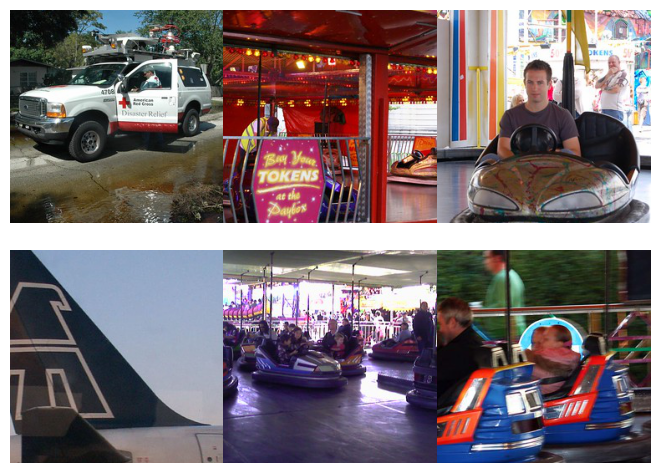

C:\Users\wgaud\miniconda3\lib\site-packages\skimage\_shared\utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)


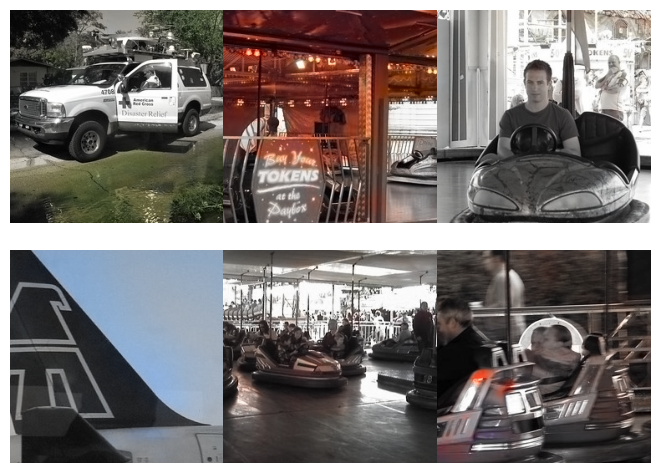

In [55]:
show(images)
new = m.predict(images)
show(new)

#######################################################################
Epoch: 0, Train loss: 3.595993302085183, Validation loss: 3.296537331172398, Time: 0:01:20.150633
#######################################################################
#######################################################################
Epoch: 1, Train loss: 3.2913322188637473, Validation loss: 3.3276121275765553, Time: 0:01:19.816078
#######################################################################
#######################################################################
Epoch: 2, Train loss: 3.2696047739549114, Validation loss: 3.3684203965323314, Time: 0:01:17.754016
#######################################################################
#######################################################################
Epoch: 3, Train loss: 3.259585718675093, Validation loss: 3.363743373325893, Time: 0:01:17.439882
#######################################################################
############################

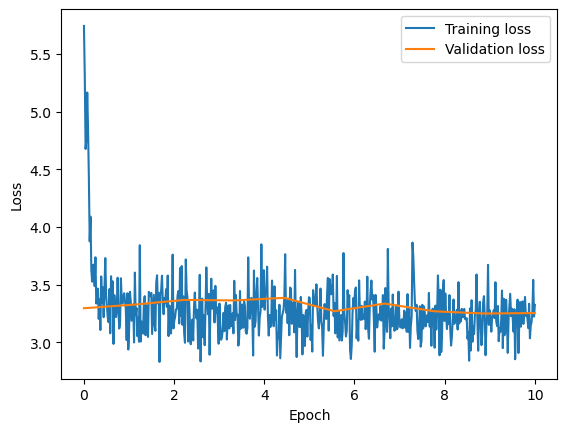

In [11]:
m.train_model(train, val, 100)

In [48]:
m.test(train)

321